In [1]:

data_dir = "f:\DEPI Microsoft Machine Learning\Round2\GP\Dataset GTSRB"
train_dir = "f:\DEPI Microsoft Machine Learning\Round2\GP\Dataset GTSRB\Train"
test_dir = "f:\DEPI Microsoft Machine Learning\Round2\GP\Dataset GTSRB\Test"

In [2]:
# Fundamental classes
import numpy as np
import pandas as pd
import tensorflow as tf
import os
import random
import seaborn as sns
import cv2
from PIL import Image
import matplotlib.pyplot as plt
from matplotlib.image import imread
from tensorflow import keras
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import accuracy_score
np.random.seed(42)

from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras.utils import to_categorical



#Loading the Data


In [3]:
def preprocess_pipeline(train_dir, target_size=(32, 32)):
    data = []
    labels = []
    for label in os.listdir(train_dir):
        class_path = os.path.join(train_dir, label)
        for img_name in os.listdir(class_path):
            img = Image.open(os.path.join(class_path, img_name))
            img = img.resize(target_size)
            img = np.array(img) / 255.0
            data.append(img)
            labels.append(int(label))
    return np.array(data), np.array(labels)


In [4]:
data, labels = preprocess_pipeline(train_dir, target_size=(32, 32))

FileNotFoundError: [Errno 2] No such file or directory: 'f:\\DEPI Microsoft Machine Learning\\Round2\\GP\\Dataset GTSRB\\Train'

In [ ]:
print(data.shape)  # (num_samples, height, width, channels)
print(labels.shape)  # (num_samples,)

(39209, 32, 32, 3)
(39209,)


### Class Distribution Analysis

In [ ]:
num_classes = 43
def plot_class_distribution(train_dir, num_classes):
    # Initialize empty lists to store the count of images and class IDs
    class_counts = []
    class_ids = []

    # Loop through each class ID (from 0 to num_classes-1)
    for class_id in range(num_classes):
        # Build the path for each class directory
        class_path = os.path.join(train_dir, str(class_id))
        # Append the count of files (images) in each class directory to class_counts
        class_counts.append(len(os.listdir(class_path)))
        # Append the class ID to the class_ids list
        class_ids.append(class_id)

    # Create a bar plot to visualize the distribution of images per class
    plt.figure(figsize=(15, 8))
    sns.barplot(x=class_ids, y=class_counts, palette="viridis")
    plt.title("Class Distribution (Number of Images per Class)", fontsize=16)
    plt.xlabel("Class ID", fontsize=14)
    plt.ylabel("Number of Images", fontsize=14)
    plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
    plt.grid(axis='y', linestyle='--', alpha=0.7)  # Add a grid for the y-axis with dashed lines
    plt.show()

    # Calculate and print the class imbalance ratio
    max_count = max(class_counts)  # Get the maximum image count
    min_count = min(class_counts)  # Get the minimum image count
    imbalance_ratio = max_count / min_count
    print(f"Class Imbalance Ratio: {imbalance_ratio:.2f}")

    # Check if the imbalance ratio is high and print a warning message
    if imbalance_ratio > 10:
        print("Warning: Significant class imbalance detected!")
    else:
        print("Class distribution is relatively balanced.")


C:\Users\Abdelrhman Motawea\AppData\Local\Temp\ipykernel_23684\1745311760.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=class_ids, y=class_counts, palette="viridis")


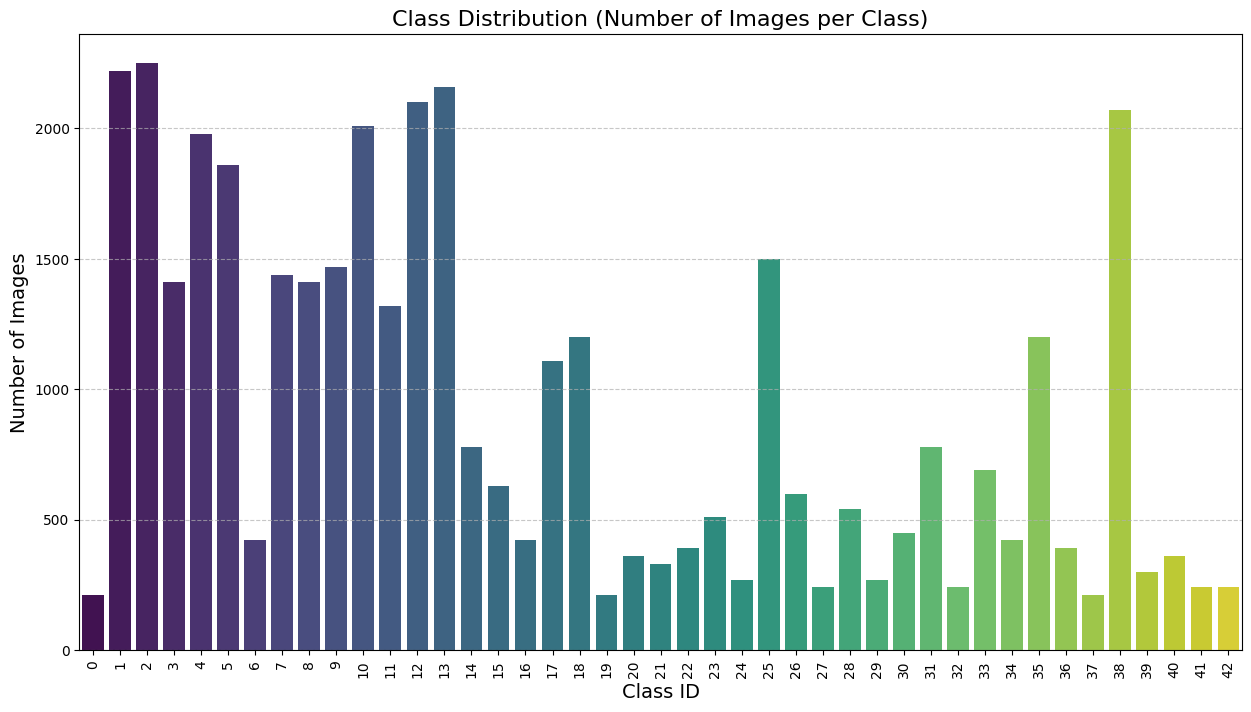

Class Imbalance Ratio: 10.71


In [ ]:
plot_class_distribution(train_dir, num_classes)

The distribution of images across classes shows significant class imbalance, with the number of images per class varying widely. The imbalance ratio of 10.71 indicates that the largest class contains over ten times the number of images compared to the smallest class. This imbalance may lead to biased model training, favoring the majority classes and underperforming on minority classes.


### Sample Images Visualization

In [ ]:

def visualize_random_samples(train_dir, num_classes, samples_per_class=4):
    # Set up the figure size for displaying the images
    plt.figure(figsize=(100, 105))

    # Loop through each class to visualize random samples
    for class_id in range(num_classes):
        class_path = os.path.join(train_dir, str(class_id))
        # we get a list of all image files in the class directory
        all_images = os.listdir(class_path)
        # Randomly select 'samples_per_class' images from the class
        random_images = random.sample(all_images, samples_per_class)

        # Loop through the selected random images and plot them
        for i, image_name in enumerate(random_images):
            plt.subplot(num_classes, samples_per_class, class_id * samples_per_class + i + 1)
            img = Image.open(os.path.join(class_path, image_name))
            plt.imshow(img)
            plt.title(f"Class {class_id}", fontsize=8)
            plt.axis('off')

    plt.tight_layout()
    plt.suptitle("Random Samples from Each Class", fontsize=20, y=1.02)
    plt.show()


In [ ]:
visualize_random_samples(train_dir, num_classes)

This visual shows a diverse sample of traffic signs from multiple classes in the dataset. The images vary in quality, lighting, and angle, which may pose challenges for classification models. Ensuring proper preprocessing, including normalization and data augmentation, will help improve model robustness in recognizing these signs under different conditions.

In [ ]:
def analyze_image_quality(train_dir, num_classes):
    resolutions = []
    for class_id in range(num_classes):
        class_path = os.path.join(train_dir, str(class_id))
        images = os.listdir(class_path)
        for image_name in images:
            img = Image.open(os.path.join(class_path, image_name))
            resolutions.append(img.size)  # Store image dimensions (width, height)

    # Convert resolutions to a DataFrame for easier analysis
    resolutions_df = pd.DataFrame(resolutions, columns=['Width', 'Height'])

    # Plot resolution distribution
    plt.figure(figsize=(10, 6))
    sns.scatterplot(data=resolutions_df, x='Width', y='Height', alpha=0.6)
    plt.title("Image Resolution Distribution", fontsize=16)
    plt.xlabel("Width", fontsize=14)
    plt.ylabel("Height", fontsize=14)
    plt.grid(linestyle='--', alpha=0.7)
    plt.show()

    # Print summary statistics
    print("Image Resolution Summary:")
    print(resolutions_df.describe())

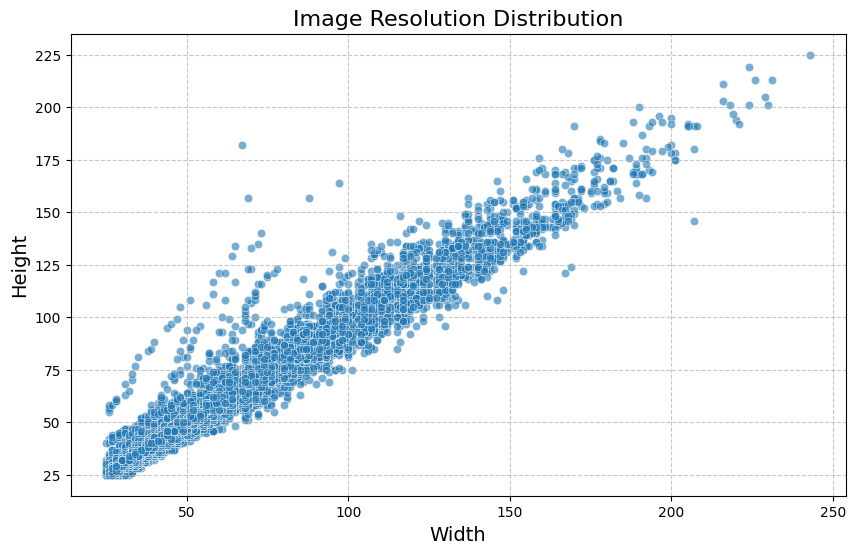

Image Resolution Summary:
              Width        Height
count  39209.000000  39209.000000
mean      50.835880     50.328930
std       24.306933     23.115423
min       25.000000     25.000000
25%       35.000000     35.000000
50%       43.000000     43.000000
75%       58.000000     58.000000
max      243.000000    225.000000


In [ ]:
analyze_image_quality(train_dir, num_classes)

The scatter plot illustrates the distribution of image resolutions, showing a positive correlation between width and height. Most images are clustered around similar resolutions, with a few outliers of varying dimensions. Standardizing image sizes through resizing or padding will be crucial to ensure consistent input for the machine learning model.

In [ ]:
# 4. **Class Imbalance Analysis**
def analyze_class_imbalance(train_dir, num_classes):
    class_counts = []
    for class_id in range(num_classes):
        class_path = os.path.join(train_dir, str(class_id))
        class_counts.append(len(os.listdir(class_path)))

    # Plot histogram of class counts
    plt.figure(figsize=(10, 6))
    sns.histplot(class_counts, bins=20, kde=True, color='blue')
    plt.title("Distribution of Class Counts", fontsize=16)
    plt.xlabel("Number of Images per Class", fontsize=14)
    plt.ylabel("Frequency", fontsize=14)
    plt.grid(linestyle='--', alpha=0.7)
    plt.show()

    # Print top 5 and bottom 5 classes
    class_count_dict = {i: count for i, count in enumerate(class_counts)}
    sorted_classes = sorted(class_count_dict.items(), key=lambda x: x[1])
    print("Top 5 Classes with Most Images:")
    for class_id, count in sorted_classes[-5:]:
        print(f"Class {class_id}: {count} images")
    print("\nTop 5 Classes with Fewest Images:")
    for class_id, count in sorted_classes[:5]:
        print(f"Class {class_id}: {count} images")

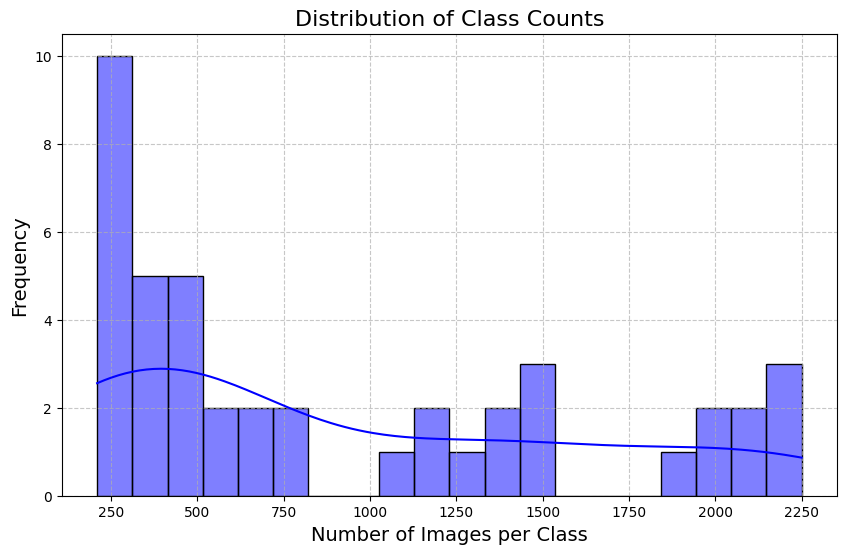

Top 5 Classes with Most Images:
Class 38: 2070 images
Class 12: 2100 images
Class 13: 2160 images
Class 1: 2220 images
Class 2: 2250 images

Top 5 Classes with Fewest Images:
Class 0: 210 images
Class 19: 210 images
Class 37: 210 images
Class 27: 240 images
Class 32: 240 images


In [ ]:
analyze_class_imbalance(train_dir, num_classes)

# Shuffling the training data does the following

1-Prevents Model Overfitting by preventing the model from learning specific patterns or relationships that are tied to the order of the data

2-Ensures Generalization and ensures that the model sees examples from different parts of the dataset during each epoch

3-More Robust Training


In [ ]:
#makes an array of indecies from 0 till the number of images
shuffle_indexes = np.arange(data.shape[0]) #shape[0] is the number of images
#shuffle those indecies
np.random.shuffle(shuffle_indexes)
#Create new list with the newly shuffled idecies
data = data[shuffle_indexes]
labels = labels[shuffle_indexes]

The dataset is already split into Train  and Test sets so all we need now to split the train into train and validation


In [ ]:

# Splitting training and Validation dataset
X_train, X_val, y_train, y_val  = train_test_split(data, labels, test_size=0.2, random_state=42, shuffle=True)



### Normalizing the Images
 Neural networks perform better when inputs are in a smaller range
 Helps with faster convergence and better training stability.

In [ ]:
X_train = X_train/255
X_val = X_val/255

print("X_train.shape", X_train.shape)
print("X_valid.shape", X_val.shape)
print("y_train.shape", y_train.shape)
print("y_valid.shape", y_val.shape)

X_train.shape (31367, 32, 32, 3)
X_valid.shape (7842, 32, 32, 3)
y_train.shape (31367,)
y_valid.shape (7842,)


### One-Hot-Encoding

In [ ]:
from tensorflow import keras

y_train = keras.utils.to_categorical(y_train, 43)
y_val = keras.utils.to_categorical(y_val, 43)

print(y_train.shape)
print(y_val.shape)

(31367, 43)
(7842, 43)


Removing Noise using GuassianBlur

This step can be skipped and only used when the model performance is poor

### Data Augmentation
 The porpuse of data augmentation is to provide a variety in the training data to improve the robustness and generalization ability of the model.

 Note: This function is applied to the data during training

## Image Classification

In [ ]:
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout

model = Sequential()
model.add(Conv2D(filters=32, kernel_size=(5,5), activation='relu', input_shape=X_train.shape[1:]))
model.add(Conv2D(filters=64, kernel_size=(5,5), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(rate=0.15))
model.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu'))
model.add(Conv2D(filters=256, kernel_size=(3, 3), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(rate=0.20))
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(rate=0.25))
model.add(Dense(43, activation='softmax'))

# Compilation of the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

#M odel display
model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_46 (Conv2D)          (None, 28, 28, 32)        2432      
                                                                 
 conv2d_47 (Conv2D)          (None, 24, 24, 64)        51264     
                                                                 
 max_pooling2d_22 (MaxPooli  (None, 12, 12, 64)        0         
 ng2D)                                                           
                                                                 
 dropout_24 (Dropout)        (None, 12, 12, 64)        0         
                                                                 
 conv2d_48 (Conv2D)          (None, 10, 10, 128)       73856     
                                                                 
 conv2d_49 (Conv2D)          (None, 8, 8, 256)         295168    
                                                     

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.optimizers import Adam

# Define the learning rate schedule
initial_learning_rate = 0.001
lr_schedule = ExponentialDecay(
    initial_learning_rate,
    decay_steps=1000,
    decay_rate=0.96,  # Reduce LR every 1000 steps
    staircase=True
)

# Adam optimizer
opt = Adam(learning_rate=lr_schedule)

# Compile
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

# Train the model on GPU
with tf.device('/GPU:0'):
    epochs = 35
    history1 = model.fit(X_train, y_train, batch_size=128, epochs=epochs, validation_data=(X_val, y_val))

# Save the model
model.save("model.h5")
print("Model saved as model.h5")


Epoch 1/35
246/246 [==============================] - 173s 685ms/step - loss: 3.4245 - accuracy: 0.0771 - val_loss: 3.1192 - val_accuracy: 0.1702
Epoch 2/35
246/246 [==============================] - 146s 593ms/step - loss: 1.6811 - accuracy: 0.5146 - val_loss: 0.6256 - val_accuracy: 0.8196
Epoch 3/35
246/246 [==============================] - 150s 608ms/step - loss: 0.5636 - accuracy: 0.8223 - val_loss: 0.2563 - val_accuracy: 0.9269
Epoch 4/35
246/246 [==============================] - 150s 610ms/step - loss: 0.3025 - accuracy: 0.9063 - val_loss: 0.1424 - val_accuracy: 0.9624
Epoch 5/35
246/246 [==============================] - 148s 601ms/step - loss: 0.1916 - accuracy: 0.9398 - val_loss: 0.1118 - val_accuracy: 0.9688
Epoch 6/35
246/246 [==============================] - 152s 617ms/step - loss: 0.1461 - accuracy: 0.9550 - val_loss: 0.0797 - val_accuracy: 0.9802
Epoch 7/35
246/246 [==============================] - 149s 606ms/step - loss: 0.1091 - accuracy: 0.9654 - val_loss: 0.0599 -

c:\Users\Abdelrhman Motawea\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Model saved as model.h5


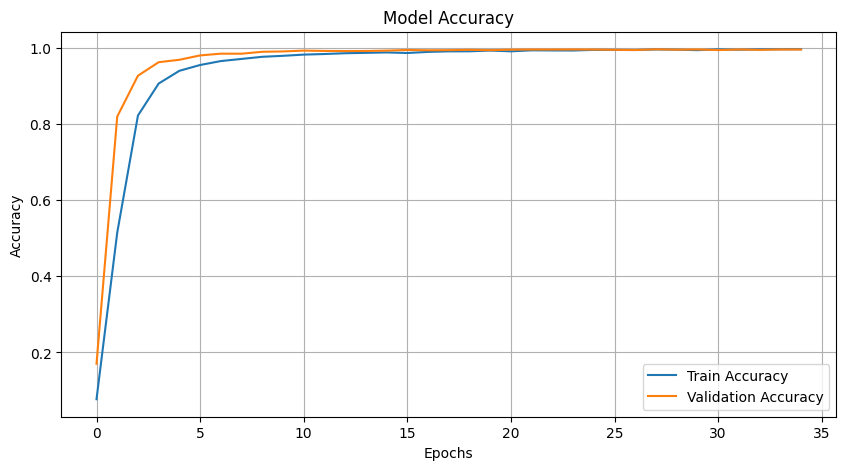

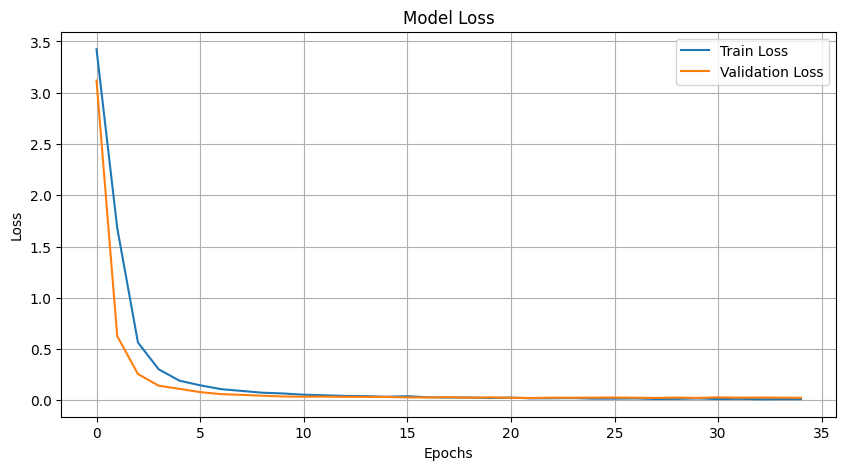

In [ ]:
import matplotlib.pyplot as plt

# Plot Accuracy
plt.figure(figsize=(10, 5))
plt.plot(history1.history['accuracy'], label='Train Accuracy')
plt.plot(history1.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')
plt.legend()
plt.grid()
plt.show()

# Plot Loss
plt.figure(figsize=(10, 5))
plt.plot(history1.history['loss'], label='Train Loss')
plt.plot(history1.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')
plt.legend()
plt.grid()
plt.show()


In [ ]:
loss, accuracy = model.evaluate(X_val, y_val)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4%}")

246/246 [==============================] - 10s 42ms/step - loss: 0.0246 - accuracy: 0.9958
Test Loss: 0.0246
Test Accuracy: 99.5792%


In [ ]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image

# Define test dataset path
test_csv_path = r"F:\DEPI Microsoft Machine Learning\Round2\GP\Dataset GTSRB\Test.csv"
#test_dir = r"F:\DEPI Microsoft Machine Learning\Round2\GP\Dataset GTSRB\Test"

# Load test labels from CSV
y_test_df = pd.read_csv(test_csv_path)

# Extract labels and image paths
labels = y_test_df["ClassId"].values
image_paths = y_test_df["Path"].values

# Preprocess test images
X_test = []

with tf.device('/GPU:0'):
    for img in image_paths:
        img_path = os.path.join(test_dir, os.path.basename(img))  # Fix file path issue
        if not os.path.exists(img_path):  # Handle missing files
            print(f"Warning: {img_path} not found!")
            continue
        image = Image.open(img_path)
        image = image.resize((32, 32))  # Match model input size
        image = np.array(image) / 255.0  # Normalize
        X_test.append(image)

# Convert to NumPy array
X_test = np.array(X_test)

#load the model
model = keras.models.load_model("model.h5")

# Model Predictions
with tf.device('/GPU:0'):
    pred = np.argmax(model.predict(X_test), axis=-1)

# Calculate Accuracy
accuracy = accuracy_score(labels[:len(pred)], pred)  # Ensure same length
print(f"Test Accuracy: {accuracy:.4%}")



395/395 [==============================] - 24s 60ms/step
Test Accuracy: 91.9240%


In [ ]:
# Load ResNet50 without top layers
#base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
#base_model.trainable = False  # Freeze base model layers